# Generating and Segmenting with Character-Level Transformer

In [1]:
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

from src.models.gpt2 import GPT2FeatureModel, GPT2LMHeadModel
from src.preprocessing import create_phoneme_map

phoible = pd.read_csv('../../data/phoible.csv')

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_76197/1418795739.py:13: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv('../../data/phoible.csv')


## Load model

In [2]:
tokenizer = AutoTokenizer.from_pretrained('transformersegmentation/CHILDES-phoneme-tokenizer')
phoneme_map = create_phoneme_map(tokenizer, '../../data/phoible.csv')
#model = GPT2FeatureModel.from_pretrained('transformersegmentation/GPT2-gpt2_feature_model-model', revision='english', feature_map=phoneme_map)
#model.return_token_logits = True
model = GPT2LMHeadModel.from_pretrained('transformersegmentation/dropout-gpt2_lm_head_model-model', revision='English-01560')

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/analysis/segmentation/../../src/preprocessing.py:29: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv(phoible_data_path)


## Load corpus

In [3]:
dataset = load_dataset('transformersegmentation/CHILDES', 'English', split='valid')
dataset = dataset.select(range(1000))

## Generate Text

In [4]:
# Generate a sample
input_ids = tokenizer.encode('h', return_tensors='pt')
sample_outputs = model.generate(input_ids, do_sample=True, max_length=50, top_k=10, top_p=0.95, num_return_sequences=3, pad_token_id=tokenizer.pad_token_id)
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=False)))


0: h ʌ UTT_BOUNDARY w ʌ t d uː j uː h æ f t ə d uː UTT_BOUNDARY ð ɪ s ɪ z j ʊ ɹ p ɑ k ɪ t b ʊ k b ʌ t w ɛ ɹ ɪ z f aɪ ə ɹ t ɹ ʌ k
1: h iː z s oʊ h æ p i UTT_BOUNDARY ð æ t s ʌ t ɹ æ k t ə ɹ UTT_BOUNDARY w ʌ t s ʌ n d ə ɹ ð ɛ ɹ UTT_BOUNDARY w ʌ t s ð æ t UTT_BOUNDARY w ɛ ɹ d uː j
2: h æ d ʌ l ɪ t ə l t ɔɪ l ɪ t p l eɪ t t ʊ ʌ n ʌ ð ə ɹ p l æ n w ʌ n UTT_BOUNDARY aɪ d oʊ n t n oʊ ɪ f ɪ t ə l s t eɪ


## Prediction Error

Plotting of prediction error from a model given a prompt.

In [5]:
from src.evaluation.segmentation import GPT2FeaturesSegmenter, GPT2Segmenter
segmenter = GPT2Segmenter(model, tokenizer, dataset['phonemized_utterance'], stride=10, batch_size=32)
#segmenter = GPT2FeaturesSegmenter(model, tokenizer, dataset['train']['phonemized_utterance'][:3000], stride=0)

100%|██████████| 43/43 [00:24<00:00,  1.78it/s]


In [15]:
def plot_utterance(data, measures, cutoffs=None):
    """ Plots a single utterance against each measure in `data` to visualise segmentation. 
    Parameters
    ----------
    data : dict
        A processed utterance containing statistical and boundary information. See `process_utterance` method above.
    measures : sequence of str
        List of keys in `data` to plot.
    cutoffs : sequence of str, optional
        Cutoff values used for segmentation, plotted as horizontal lines on each plot.
    """
    _, axs = plt.subplots(len(measures),1, figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.plot('Pos', measures[i], data=data)
        ax.set_ylabel(measures[i])
        ax.set_xticks(data.Pos, data.Phoneme)

        cutoff = cutoffs[i] if cutoffs else None
        for j in range(len(ax.get_xticklabels())):
            tick = ax.get_xticklabels()[j]
            is_boundary = data.Starts[j]
            y_value = data[measures[i]].values[j]
            # Add vertical line at boundary
            if is_boundary:
                ax.axvline(x=j, color='grey', alpha=0.5)
            # Set tick to green if correct boundary according to cutoff
            if cutoff:
                tick.set_color('green' if (is_boundary and y_value >= cutoff) or (not is_boundary and y_value < cutoff) else 'red')

        # Add cutoff line   
        if cutoff:
            ax.axhline(y=cutoff, color='pink', alpha=0.5)

    ax.set_xlabel('Phonemes')
    plt.show()

def get_cutoff_data(segmenter, measure, cutoffs):
    """ Get results for a specific measure at different cutoffs. """
    all_results = []
    for cutoff in cutoffs:
        results = segmenter.evaluate_cutoff_segmentation(measure, cutoff)
        results['Cutoff'] = cutoff
        all_results.append(results)
    all_results = pd.concat(all_results)
    return all_results

def plot_scores_by_cutoff(results):
    """ Plot each measure against the different cutoffs used. Adds a vertical and horizontal line at the best value for each score. """
    num_columns = 3
    scores = sorted(list(set(results.keys()) - {'Cutoff'}))
    num_rows = len(results.keys()) // num_columns
    _, axs = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    column = 0
    for i, score in enumerate(scores):
        graph = sns.lineplot(results, x='Cutoff', y=score, ax=axs[i//num_columns, column])
        max_score = results[results[score] == results[score].max()].head(1)
        max_cutoff = float(max_score['Cutoff'])
        max_score = float(max_score[score])
        graph.axvline(max_cutoff, color='grey', alpha=0.5)
        graph.axhline(max_score, color='pink', alpha=0.5)
        graph.set_ybound(0,1)
        column = (column + 1) % num_columns
    plt.show()

def plot_roc(results, measure1, measure2):
    """ Plot two scores against each other (e.g. precision against recall) """
    sns.lineplot(results, x=measure1, y=measure2)
    plt.show()

def plot_optimal_cutoff(segmenter, measure, score, cutoff):

    min, max = segmenter.processed_utterances[measure].min(), segmenter.processed_utterances[measure].max()
    cutoffs = np.linspace(min, max, 50)
    scores = [segmenter.evaluate_cutoff_segmentation(measure, cutoff)[score] for cutoff in cutoffs]
    graph = sns.lineplot(x=cutoffs, y=scores)
    graph.axvline(cutoff, color='grey', alpha=0.5)
    plt.show()

def summarise_segmentation(segmenter, measure='Entropy', score='type_fscore', cutoff=None, show_plots=False):
    spike_data = segmenter.evaluate_spike_segmentation(measure)
    print('Spike {}: {}'.format(score, round(spike_data[score]*100,2)))
    if cutoff:
        best_cutoff = cutoff
        best_result = segmenter.evaluate_cutoff_segmentation(measure, cutoff)[score]
    else:
        best_cutoff, best_result = segmenter.find_best_cutoff(measure, score)
        print('Best cutoff:', best_cutoff)
    print('Best {} at cutoff {}: {}'.format(score, best_cutoff, round(best_result*100, 2)))
    if show_plots:
        plot_optimal_cutoff(segmenter, measure, score, best_cutoff)


In [16]:
all_measures = ['Entropy', 'Increase in Entropy', 'Boundary Prediction', 'Increase in Boundary Prediction', 'Loss', 'Increase in Loss', 'Rank', 'Increase in Rank']
all_measures = ['Entropy', 'Boundary Prediction', 'Loss', 'Rank']
best_cutoffs = {measure : segmenter.find_best_cutoff(measure, 'boundary_noedge_fscore')[0] for measure in all_measures}

print("Best cutoffs: ", best_cutoffs)

Best cutoffs:  {'Entropy': 1.6267325857565265, 'Boundary Prediction': 0.0006617960598549573, 'Loss': 0.9421654946614525, 'Rank': 1.2388715053509205}


In [17]:
# segmenter.processed_utterances['Majority Vote Cutoff'] = 0
# segmenter.processed_utterances['Majority Vote Spike'] = 0
# for measure in all_measures:
#     segmenter.processed_utterances['Majority Vote Cutoff'] += (segmenter.processed_utterances[measure] >= best_cutoffs[measure]).astype(int)
#     shift_left = segmenter.processed_utterances[measure].shift(1)
#     shift_right = segmenter.processed_utterances[measure].shift(-1)
#     segmenter.processed_utterances['Majority Vote Spike'] += ((segmenter.processed_utterances[measure] > shift_left) & (segmenter.processed_utterances[measure] > shift_right)).astype(int)

segmenter.add_majority_vote(best_cutoffs)

best_cutoffs['Majority Vote Cutoff'] = 0.5
best_cutoffs['Majority Vote Spike'] = 0.5
all_measures += ['Majority Vote Cutoff', 'Majority Vote Spike']

In [18]:
example_utterance = segmenter.processed_utterances.loc[0:64].copy()
example_utterance.Phoneme = example_utterance.Phoneme.apply(lambda x: x if x != 'UTT_BOUNDARY' else ' ')

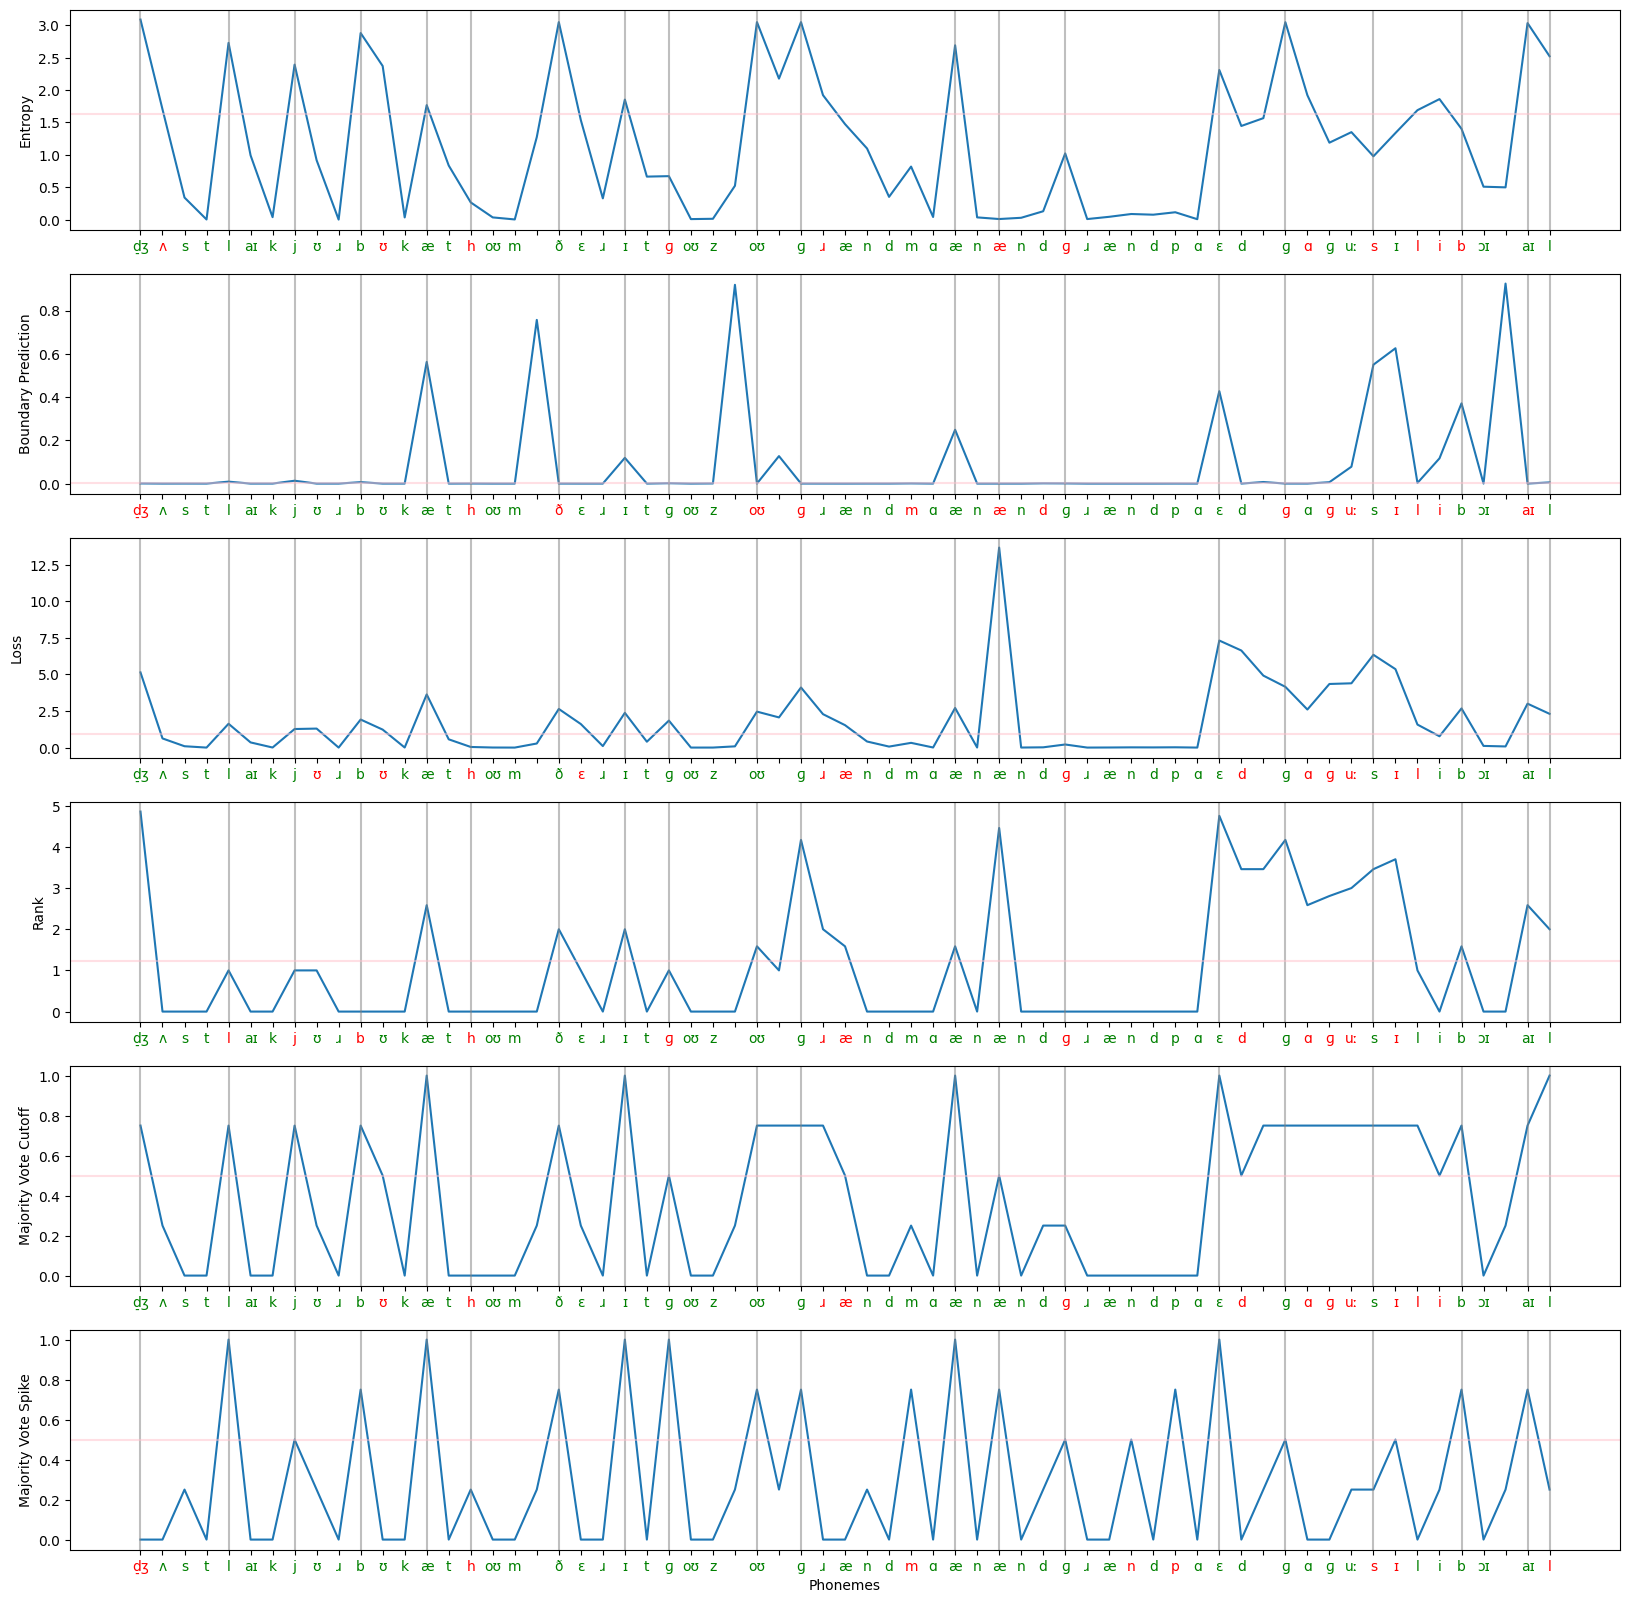

d̠ʒʌstlaɪkjʊɹbʊkæthoʊm ðɛɹɪtɡoʊz oʊ ɡɹændmɑænændɡɹændpɑɛd ɡɑɡuːsɪlibɔɪ aɪl


In [19]:
plot_utterance(example_utterance, list(best_cutoffs.keys()), list(best_cutoffs.values()))
#plot_utterance(data, ['Feature Loss', 'Feature Entropy', 'Loss Deviation', 'Boundary Feature Prediction'], [0.01, 0.3, 0.01, 0.5])
print(''.join(list(example_utterance.Phoneme)))


Entropy
Spike type_fscore: 43.22
Best type_fscore at cutoff 1.6267325857565265: 32.98


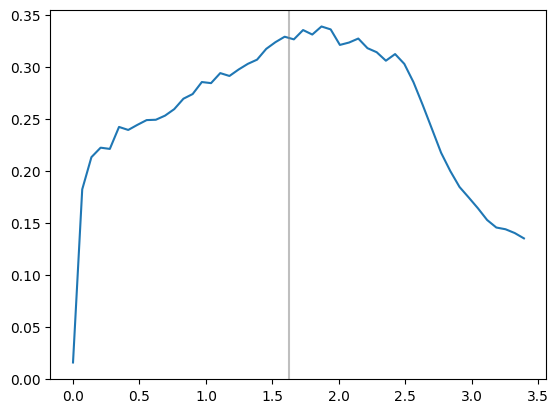


Boundary Prediction
Spike type_fscore: 46.14
Best type_fscore at cutoff 0.0006617960598549573: 48.37


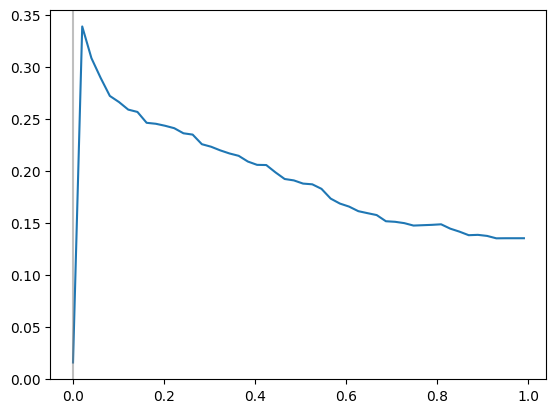


Loss
Spike type_fscore: 39.95
Best type_fscore at cutoff 0.9421654946614525: 27.6


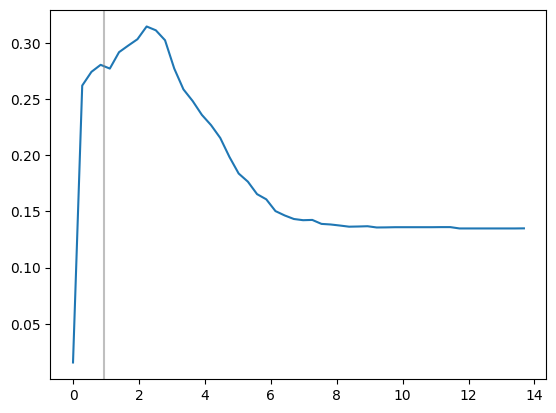


Rank
Spike type_fscore: 39.87
Best type_fscore at cutoff 1.2388715053509205: 29.87


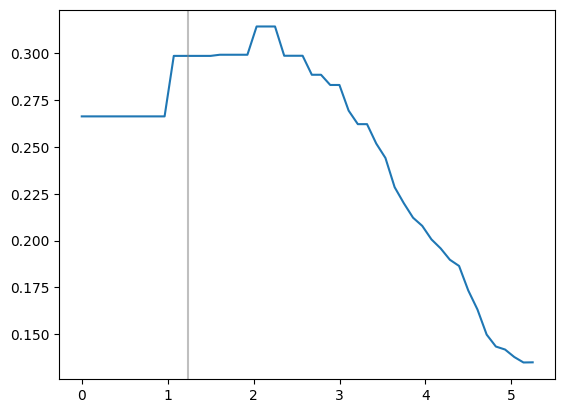


Majority Vote Cutoff
Spike type_fscore: 49.23
Best type_fscore at cutoff 0.5: 41.24


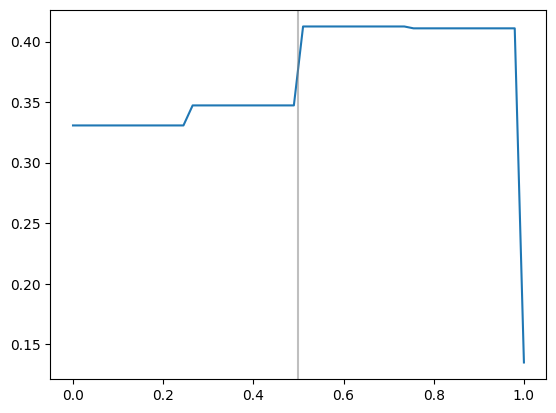


Majority Vote Spike
Spike type_fscore: 40.16
Best type_fscore at cutoff 0.5: 47.96


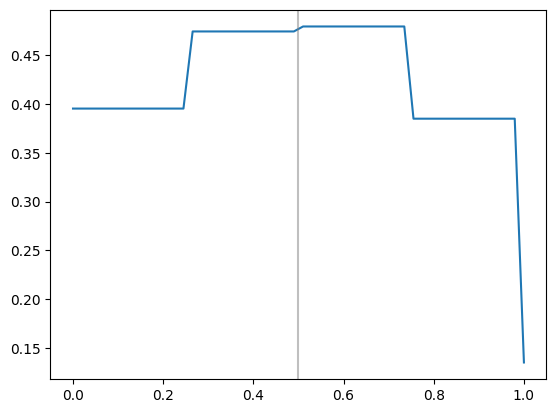

In [20]:
for measure in all_measures:
    print('\n' + measure)
    summarise_segmentation(segmenter, measure, 'type_fscore', best_cutoffs[measure], show_plots=True)
#for measure in ['Feature Loss', 'Increase in Feature Loss', 'Feature Entropy', 'Increase in Feature Entropy', 'Loss Deviation', 'Increase in Loss Deviation', 'Boundary Feature Prediction', 'Increase in Boundary Feature Prediction']:


Entropy
Spike type_fscore: 43.22
Best cutoff: 1.7701709951537985
Best type_fscore at cutoff 1.7701709951537985: 33.16


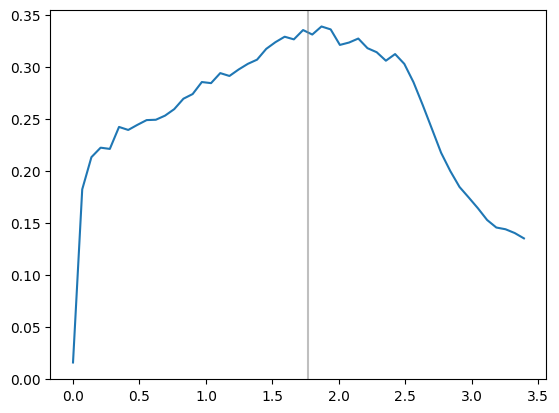


Boundary Prediction
Spike type_fscore: 46.14
Best cutoff: 0.019449778430790626
Best type_fscore at cutoff 0.019449778430790626: 34.15


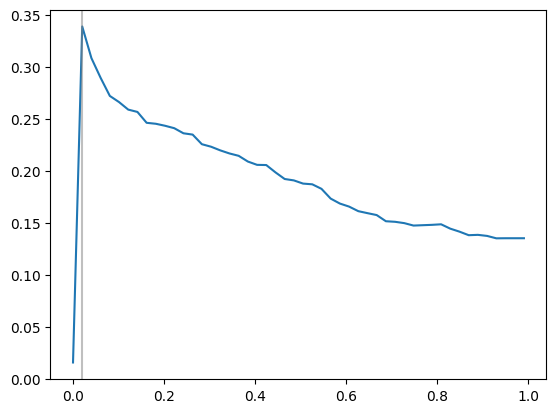


Loss
Spike type_fscore: 39.95
Best cutoff: 2.4429248874591405
Best type_fscore at cutoff 2.4429248874591405: 31.24


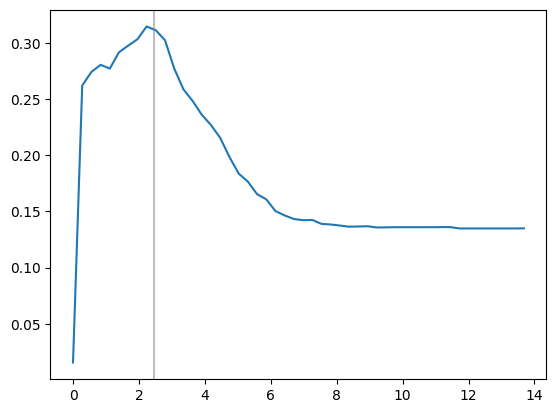


Rank
Spike type_fscore: 39.87
Best cutoff: 2.0045359140018855
Best type_fscore at cutoff 2.0045359140018855: 31.44


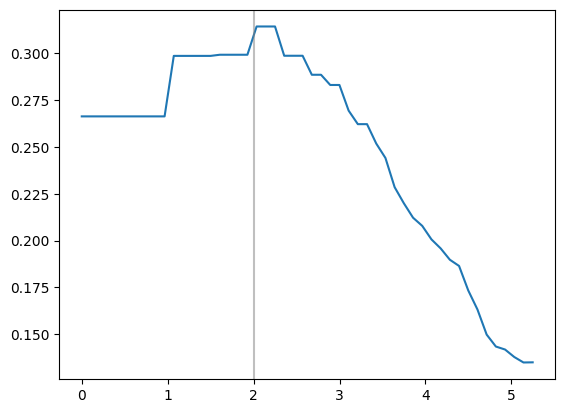


Majority Vote Cutoff
Spike type_fscore: 49.23
Best cutoff: 0.5883541454758293
Best type_fscore at cutoff 0.5883541454758293: 41.24


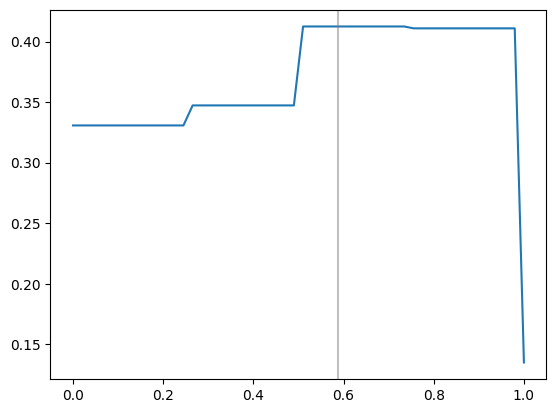


Majority Vote Spike
Spike type_fscore: 40.16
Best cutoff: 0.5123888128699597
Best type_fscore at cutoff 0.5123888128699597: 47.96


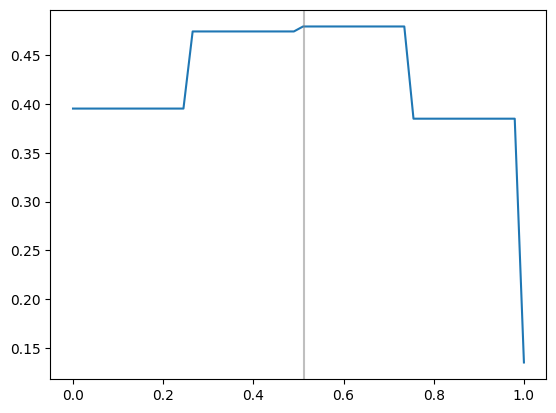

In [21]:
for measure in all_measures:
    print('\n' + measure)
    summarise_segmentation(segmenter, measure, 'type_fscore', show_plots=True)

Spike boundary_noedge_fscore: 78.63
Best boundary_noedge_fscore at cutoff 0.5: 71.26


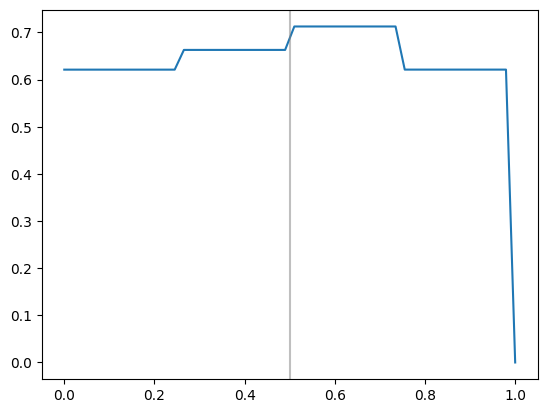

Spike boundary_noedge_fscore: 74.0
Best boundary_noedge_fscore at cutoff 0.5: 75.5


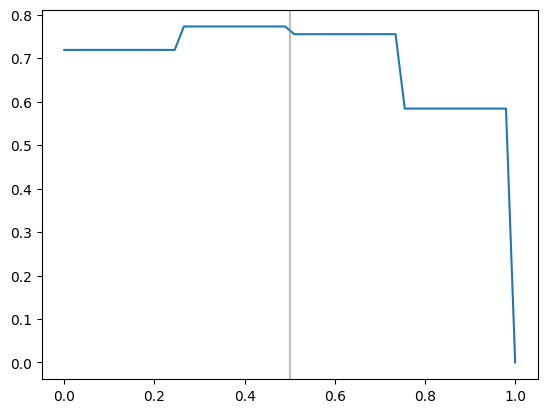

In [22]:
summarise_segmentation(segmenter, 'Majority Vote Cutoff', 'boundary_noedge_fscore', show_plots=True, cutoff=best_cutoffs['Majority Vote Cutoff'])
summarise_segmentation(segmenter, 'Majority Vote Spike', 'boundary_noedge_fscore', show_plots=True, cutoff=best_cutoffs['Majority Vote Spike'])

Spike boundary_noedge_fscore: 78.63
Best cutoff: 0.5476359787115708
Best boundary_noedge_fscore at cutoff 0.5476359787115708: 71.26


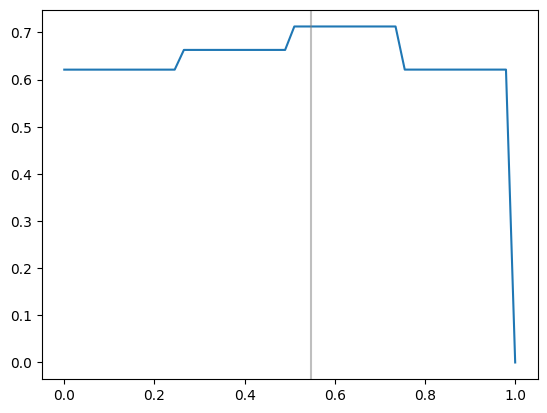

Spike boundary_noedge_fscore: 74.0
Best cutoff: 0.38196975947865036
Best boundary_noedge_fscore at cutoff 0.38196975947865036: 77.27


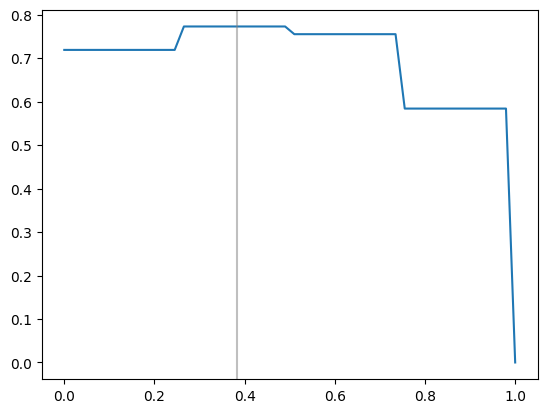

In [23]:
summarise_segmentation(segmenter, 'Majority Vote Cutoff', 'boundary_noedge_fscore', show_plots=True)
summarise_segmentation(segmenter, 'Majority Vote Spike', 'boundary_noedge_fscore', show_plots=True)